# **Sentiment Analysis for Social Media Data**

### Imports and Initializations

In [1]:
import os
import re
import emoji
import string
import pickle
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

import torch
from transformers import BertTokenizer, BertModel

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\infor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\infor\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\infor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\infor\Documents\AAIML\local_repo\venv\pytorch_gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pickle_folder = 'pickles'
sentiment_file = os.path.join( 'content', 'reddit_comments_with_sentiment.csv')
url_pattern = re.compile('http\S+|www\S+|https\S+')
random_state = 42

In [3]:
np.random.seed(random_state)
en_stopwords = stopwords.words('english')
punctuation_list = list(string.punctuation)
lemmatizer = WordNetLemmatizer()

### Loading Data

In [4]:
df = pd.read_csv(sentiment_file)
display(df)

,Title,Comment,upRatio,Sentiment
0,Donald Trump sells cut-up pieces of suit he wo...,"\nAs a reminder, this subreddit [is for civil ...",0.94,negative
1,Donald Trump sells cut-up pieces of suit he wo...,"Probably some rag he bought off the rack, not ...",0.94,negative
2,Donald Trump sells cut-up pieces of suit he wo...,"Just so it's clear, there will certainly be fa...",0.94,positive
3,Donald Trump sells cut-up pieces of suit he wo...,That guy was actually in the role of the presi...,0.94,negative
4,Donald Trump sells cut-up pieces of suit he wo...,It's literally a cult\n\nWhat sickos,0.94,negative
...,...,...,...,...
26694,The TikTok Panic Reached a New Level of Stupid...,Keep my daughter’s name out of your voice!!!,0.79,positive
26695,The TikTok Panic Reached a New Level of Stupid...,From reporter Jules Roscoe:\n\nIn the fourth R...,0.79,negative
26696,The TikTok Panic Reached a New Level of Stupid...,TikTok is right up there with X for platforms ...,0.79,positive
26697,The TikTok Panic Reached a New Level of Stupid...,I feel 17% stupider for having read this.,0.79,negative


In [5]:
comments_to_exclude = ['[deleted]', '[removed]']
df[df['Comment'].str.strip().isin(comments_to_exclude)]['Comment'].value_counts()

Comment
[deleted]    152
[removed]     83
Name: count, dtype: int64

In [6]:
df = df[~df['Comment'].str.strip().isin(comments_to_exclude)]
print(df.shape)
df['Sentiment'].value_counts()

(26464, 4)


Sentiment
negative    19045
positive     5858
neutral      1561
Name: count, dtype: int64

### Balancing the Classes

In [7]:
random_negative_indices = np.random.choice(df[df['Sentiment'] == 'negative'].index, 13187, replace=False)

In [8]:
df = df.drop(index=random_negative_indices)
print(df.shape)
df['Sentiment'].value_counts()

(13277, 4)


Sentiment
positive    5858
negative    5858
neutral     1561
Name: count, dtype: int64

---

## Data Preprocessing

In [9]:
def preprocess_text(input_str: str)->str:
    """
    Returns the input string after applying basic NLP tasks 
    (Stopword removal, Punctuation removal and lemmatization using POS tagging)
    """
    def get_wordnet_pos(tag):
        """
        Returns wordnet POS tag object.
        """
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
    
    # Removing links
    input_str = url_pattern.sub('', input_str)

    # Handling emojis
    input_str = emoji.demojize(input_str)

    # Tokenization 
    tokens = [
            word for word in word_tokenize(input_str) 
            if word.lower() not in en_stopwords       # stopword removal
                and word not in punctuation_list      # punctuation removal
                and not re.match(r'\W+$', word)       # removing tokens with only special chars
    ]
    
    pos_tagged = nltk.pos_tag(tokens) # POS tagging
    lemmatized_with_pos = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tagged
    ]  # Lemmatization
    cleansed_sentence = ' '.join(lemmatized_with_pos).lower() # Case folding

    return cleansed_sentence

In [ ]:
# for comment in df['Comment'].loc[[130, 2099, 2, 2058]]:
#     print(comment)
#     print('-' * 75)
#     print(preprocess_text(comment))
#     print('='*200)

In [10]:
df['Processed_Comment'] = df['Comment'].apply(preprocess_text)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df['Processed_Comment'], df['Sentiment'], test_size=0.25, random_state=random_state)

In [12]:
processed_data = {
    'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test':y_test
}
with open(os.path.join(pickle_folder, 'processed_data.pickle'), 'wb') as fo:
    pickle.dump(processed_data, fo)

In [ ]:
# with open(os.path.join(pickle_folder, 'processed_data.pickle'), 'rb') as fo:
#     processed_data = pickle.load(fo)
# X_train, X_test, y_train, y_test = processed_data['X_train'], processed_data['X_test'], processed_data['y_train'], processed_data['y_test']

---

## Feature Extractions

### TF-IDF

In [13]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
tfidf_features = tfidf_vectorizer.get_feature_names_out()
print(f'TF-IDF Features: {len(tfidf_features)}')

TF-IDF Features: 1000


In [14]:
df_train_vectors_tfidf = pd.DataFrame.sparse.from_spmatrix(X_train_tfidf)
df_train_vectors_tfidf.columns = tfidf_features
df_train_vectors_tfidf

,000,10,100,20,2016,2020,2024,30,40,50,...,wrong,wtf,ya,yeah,year,year ago,yes,yet,young,zero
0,0.0,0.385376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.170106,0.000000,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.076819,0.0,0.0,0.000000,0.059651,0.0,0.071932,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9952,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
9953,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
9954,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
9955,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0


In [15]:
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [16]:
with open(os.path.join(pickle_folder, 'tfidf_vectorizer.pickle'), 'wb') as fo:
    pickle.dump(tfidf_vectorizer, fo)

In [ ]:
# with open(os.path.join(pickle_folder, 'tfidf_vectorizer.pickle'), 'rb') as fo:
    # tfidf_vectorizer = pickle.load(fo)

### Word2Vec

In [17]:
tokenized_texts = [word_tokenize(text) for text in X_train]

word2vec_model = Word2Vec(
    sentences=tokenized_texts, vector_size=1000, window=5, min_count=1, workers=4
)

In [18]:
with open(os.path.join(pickle_folder, 'word2vec_model.pickle'), 'wb') as fo:
    pickle.dump(word2vec_model, fo)

In [6]:
# with open(os.path.join(pickle_folder, 'word2vec_model.pickle'), 'rb') as fo:
#     word2vec_model = pickle.load(fo)

In [19]:
def get_word2vec_features(text):
    words = word_tokenize(text)
    vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    if vectors:
        return sum(vectors) / len(vectors)
    else:
        return [0] * 1000  


In [20]:
X_train_word2vec = [get_word2vec_features(text) for text in X_train]

In [21]:
X_test_word2vec = [get_word2vec_features(text) for text in X_test]

### Context based Embeddings - BERT

In [22]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased").to('cuda:0')

In [23]:
with open(os.path.join(pickle_folder, 'bert_tokenizer.pickle'), 'wb') as fo:
    pickle.dump(tokenizer, fo)

In [24]:
with open(os.path.join(pickle_folder, 'bert_model.pickle'), 'wb') as fo:
    pickle.dump(model, fo)

In [25]:
def get_bert_embeddings(texts, batch_size=16):
    if not isinstance(texts, list):
        texts = texts.to_list()
    
    def batchify(data, batch_size):
        for i in range(0, len(data), batch_size):
            yield data[i:i + batch_size]
    
    embeddings = []
    with torch.no_grad():
        for batch_texts in batchify(texts, batch_size):
            # Tokenize and pad the input texts
            tokenized_texts = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=128).to('cuda:0')

            # Forward pass to obtain BERT embeddings
            outputs = model(**tokenized_texts)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()

            # Store the embeddings
            embeddings.extend(batch_embeddings)

    # Convert list of embeddings to a numpy array
    embeddings = np.array(embeddings)

    return embeddings


In [26]:
X_train_bert = get_bert_embeddings(X_train.to_list())

In [27]:
X_test_bert = get_bert_embeddings(X_test.to_list())

---

## Modeling

In [34]:
def show_metrics(y_actual, y_predicted, title=''):
    """ Function to calculate and display the metrics for a classification problem """
    
    plt.figure(figsize=(4.5, 3))
    _ = ConfusionMatrixDisplay.from_predictions(y_actual, y_predicted)
    if title:
        plt.title(title)
    plt.show()
    plt.savefig(os.path.join('plots', title))
    print(classification_report(y_actual, y_predicted))

In [39]:
def build_model(X_train, y_train, model_name='SVM'):
    models = {
        'SVM': SVC(), 
        'Naive-Bayes': MultinomialNB(),
        'MLP': MLPClassifier()
    }

    param_grid = {
        'SVM': {
            'C': [0.1, 1, 10],  
            'gamma': [1, 0.1, 0.01], 
            'kernel': ['rbf']
        },
        'Naive-Bayes': {
            'alpha': [0.1, 0.5, 1.0],
            'fit_prior': [True, False]
        },
        'MLP': {
            'hidden_layer_sizes': [(64, 32), (32, 16), (16, 8)],
            'learning_rate_init': [0.01, 0.1]
        }
    }  
  
    scoring_metric = 'accuracy' #'f1' if model_name == 'SVM' else 'accuracy'
    grid = GridSearchCV(models[model_name], param_grid[model_name], scoring=scoring_metric, cv=3, verbose=3) 
    grid.fit(X_train, y_train) 

    return grid.best_estimator_

Model Building for SVM using TF-IDF feature extraction
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.565 total time=   4.5s
[CV 2/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.583 total time=   4.5s
[CV 3/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.584 total time=   4.4s
[CV 1/3] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.565 total time=   4.2s
[CV 2/3] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.545 total time=   4.4s
[CV 3/3] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.600 total time=   4.2s
[CV 1/3] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.441 total time=   4.2s
[CV 2/3] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.441 total time=   4.2s
[CV 3/3] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.441 total time=   4.1s
[CV 1/3] END ..........C=1, gamma=1, kernel=rbf;, score=0.668 total time=   4.3s
[CV 2/3] END ..........C=1, gamma=1, kernel=rbf;, score=0.671 total time=  

<Figure size 450x300 with 0 Axes>

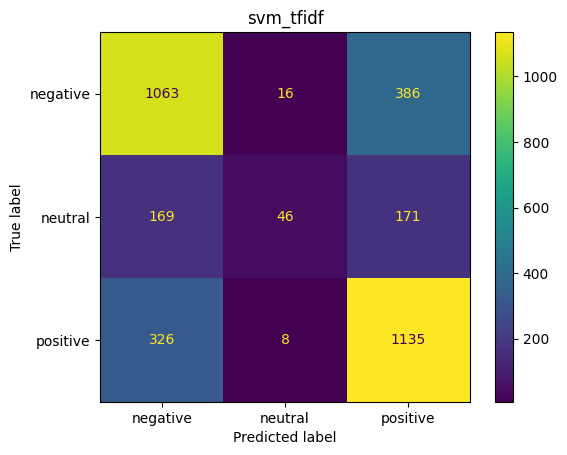

              precision    recall  f1-score   support

    negative       0.68      0.73      0.70      1465
     neutral       0.66      0.12      0.20       386
    positive       0.67      0.77      0.72      1469

    accuracy                           0.68      3320
   macro avg       0.67      0.54      0.54      3320
weighted avg       0.67      0.68      0.65      3320

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Model Building for SVM using Word2Vec feature extraction
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.531 total time= 1.1min
[CV 2/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.528 total time= 1.0min
[CV 3/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.512 total time= 1.1min
[CV 1/3] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.

<Figure size 640x480 with 0 Axes>

<Figure size 450x300 with 0 Axes>

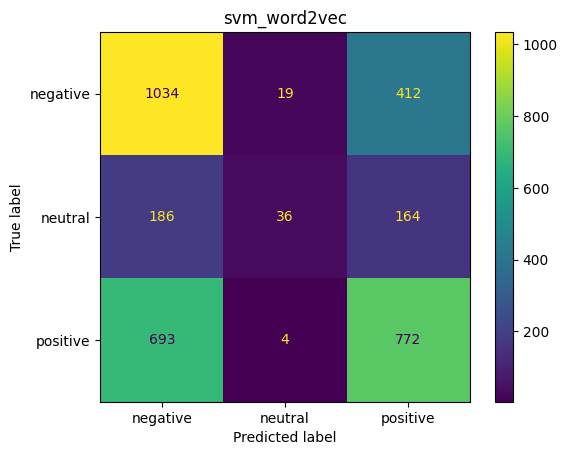

              precision    recall  f1-score   support

    negative       0.54      0.71      0.61      1465
     neutral       0.61      0.09      0.16       386
    positive       0.57      0.53      0.55      1469

    accuracy                           0.55      3320
   macro avg       0.57      0.44      0.44      3320
weighted avg       0.56      0.55      0.53      3320

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Model Building for SVM using BERT feature extraction
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.459 total time=  58.2s
[CV 2/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.455 total time=  54.5s
[CV 3/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.457 total time=  54.3s
[CV 1/3] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.603 

<Figure size 640x480 with 0 Axes>

<Figure size 450x300 with 0 Axes>

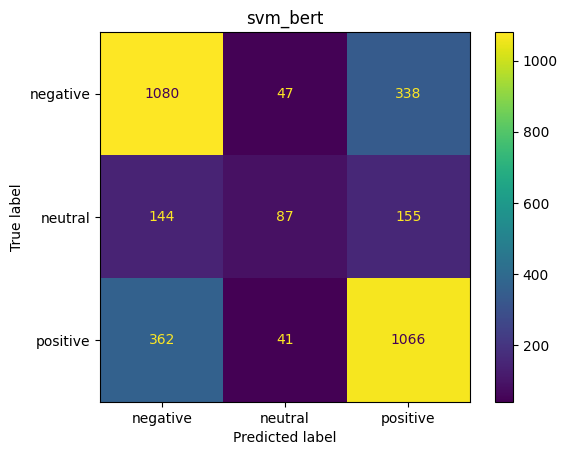

              precision    recall  f1-score   support

    negative       0.68      0.74      0.71      1465
     neutral       0.50      0.23      0.31       386
    positive       0.68      0.73      0.70      1469

    accuracy                           0.67      3320
   macro avg       0.62      0.56      0.57      3320
weighted avg       0.66      0.67      0.66      3320

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Model Building for Naive-Bayes using TF-IDF feature extraction
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Exception occured while building naivebayes_tfidf
Invalid parameter 'average' for estimator MultinomialNB(alpha=0.1). Valid parameters are: ['alpha', 'class_prior', 'fit_prior', 'force_alpha'].
-----------------------------------------------------------------------------------------------------

<Figure size 640x480 with 0 Axes>

<Figure size 450x300 with 0 Axes>

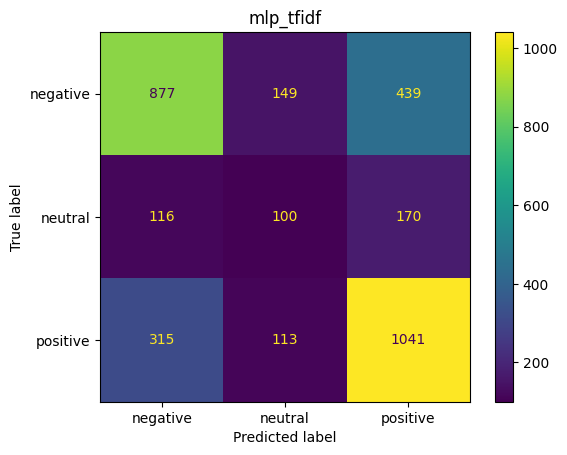

              precision    recall  f1-score   support

    negative       0.67      0.60      0.63      1465
     neutral       0.28      0.26      0.27       386
    positive       0.63      0.71      0.67      1469

    accuracy                           0.61      3320
   macro avg       0.53      0.52      0.52      3320
weighted avg       0.61      0.61      0.61      3320

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Model Building for MLP using Word2Vec feature extraction
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END hidden_layer_sizes=(64, 32), learning_rate_init=0.01;, score=0.544 total time=  10.5s
[CV 2/3] END hidden_layer_sizes=(64, 32), learning_rate_init=0.01;, score=0.536 total time=  12.5s
[CV 3/3] END hidden_layer_sizes=(64, 32), learning_rate_init=0.01;, score=0.511 total time=  15.8s
[CV 

<Figure size 640x480 with 0 Axes>

<Figure size 450x300 with 0 Axes>

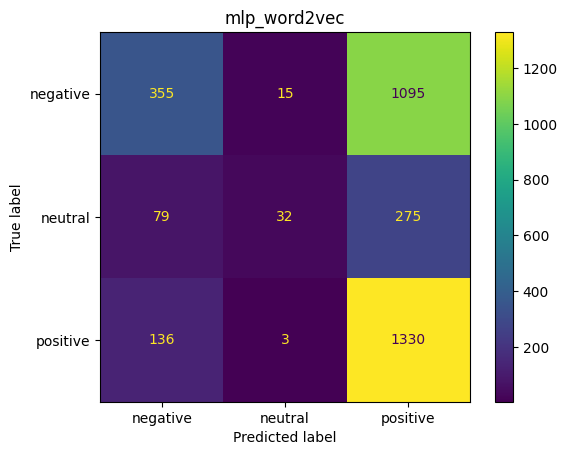

              precision    recall  f1-score   support

    negative       0.62      0.24      0.35      1465
     neutral       0.64      0.08      0.15       386
    positive       0.49      0.91      0.64      1469

    accuracy                           0.52      3320
   macro avg       0.59      0.41      0.38      3320
weighted avg       0.57      0.52      0.45      3320

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Model Building for MLP using BERT feature extraction
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END hidden_layer_sizes=(64, 32), learning_rate_init=0.01;, score=0.614 total time=  10.2s
[CV 2/3] END hidden_layer_sizes=(64, 32), learning_rate_init=0.01;, score=0.629 total time=  13.1s
[CV 3/3] END hidden_layer_sizes=(64, 32), learning_rate_init=0.01;, score=0.615 total time=  12.6s
[CV 1/3]

<Figure size 640x480 with 0 Axes>

<Figure size 450x300 with 0 Axes>

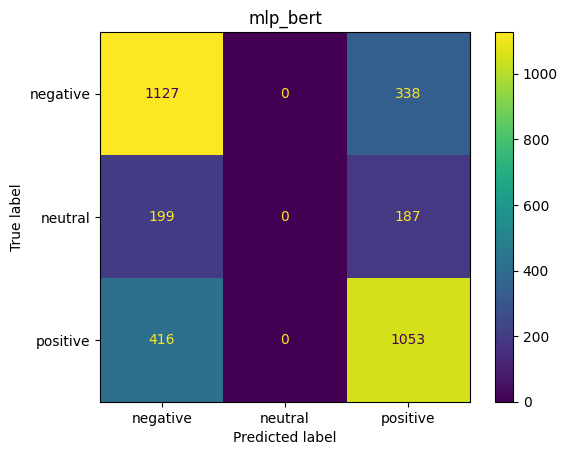

              precision    recall  f1-score   support

    negative       0.65      0.77      0.70      1465
     neutral       0.00      0.00      0.00       386
    positive       0.67      0.72      0.69      1469

    accuracy                           0.66      3320
   macro avg       0.44      0.50      0.46      3320
weighted avg       0.58      0.66      0.62      3320

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


c:\Users\infor\Documents\AAIML\local_repo\venv\pytorch_gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\infor\Documents\AAIML\local_repo\venv\pytorch_gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\infor\Documents\AAIML\local_repo\venv\pytorch_gpu\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

<Figure size 640x480 with 0 Axes>

In [36]:
metrics = []
for model_name in ['SVM', 'Naive-Bayes', 'MLP']:
    for featuring_name, X_train_features, X_test_features in [
        ('TF-IDF', X_train_tfidf, X_test_tfidf),
        ('Word2Vec', X_train_word2vec, X_test_word2vec),
        ('BERT', X_train_bert, X_test_bert)
    ]:
        print(f'Model Building for {model_name} using {featuring_name} feature extraction')
        model_full_name = model_name + '_' + featuring_name
        model_full_name = model_full_name.replace('-', '').lower()

        try:
            model = build_model(X_train_features, y_train, model_name)
            
            with open(os.path.join(pickle_folder, f'{model_full_name}.pickle'), 'wb') as fo:
                pickle.dump(model, fo)
            
            y_pred = model.predict(X_test_features)
            show_metrics(y_test, y_pred, model_full_name)
            metrics.append({
                'Model': model_name,
                'Feature': featuring_name,
                'Accuracy': accuracy_score(y_test, y_pred),
                'F1_Score': f1_score(y_test, y_pred, average='weighted'),
                'Precision': precision_score(y_test, y_pred, average='weighted'),
                'Recall': recall_score(y_test, y_pred, average='weighted')
            })
        except Exception as e:
            print(f'Exception occured while building {model_full_name}\n{e}')
        print('-' * 200)
    print('=' * 200)

In [38]:
metrics

[{'Model': 'SVM',
  'Feature': 'TF-IDF',
  'Accuracy': 0.6759036144578313,
  'F1_Score': 0.6515372682154523,
  'Precision': 0.6742817458280368,
  'Recall': 0.6759036144578313},
 {'Model': 'SVM',
  'Feature': 'Word2Vec',
  'Accuracy': 0.5548192771084337,
  'F1_Score': 0.5314704822871515,
  'Precision': 0.5628532097096547,
  'Recall': 0.5548192771084337},
 {'Model': 'SVM',
  'Feature': 'BERT',
  'Accuracy': 0.6725903614457831,
  'F1_Score': 0.6600017429740271,
  'Precision': 0.6608318463258314,
  'Recall': 0.6725903614457831},
 {'Model': 'MLP',
  'Feature': 'TF-IDF',
  'Accuracy': 0.6078313253012049,
  'F1_Score': 0.6055576179255558,
  'Precision': 0.6071391892685131,
  'Recall': 0.6078313253012049},
 {'Model': 'MLP',
  'Feature': 'Word2Vec',
  'Accuracy': 0.5171686746987951,
  'F1_Score': 0.45333599161006777,
  'Precision': 0.5671899997651424,
  'Recall': 0.5171686746987951},
 {'Model': 'MLP',
  'Feature': 'BERT',
  'Accuracy': 0.6566265060240963,
  'F1_Score': 0.615960284849616,
  'Pre

Model Building for Naive-Bayes using TF-IDF feature extraction
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END .........alpha=0.1, fit_prior=True;, score=0.612 total time=   0.0s
[CV 2/3] END .........alpha=0.1, fit_prior=True;, score=0.599 total time=   0.0s
[CV 3/3] END .........alpha=0.1, fit_prior=True;, score=0.591 total time=   0.0s
[CV 1/3] END ........alpha=0.1, fit_prior=False;, score=0.543 total time=   0.0s
[CV 2/3] END ........alpha=0.1, fit_prior=False;, score=0.540 total time=   0.0s
[CV 3/3] END ........alpha=0.1, fit_prior=False;, score=0.530 total time=   0.0s
[CV 1/3] END .........alpha=0.5, fit_prior=True;, score=0.603 total time=   0.0s
[CV 2/3] END .........alpha=0.5, fit_prior=True;, score=0.600 total time=   0.0s
[CV 3/3] END .........alpha=0.5, fit_prior=True;, score=0.588 total time=   0.0s
[CV 1/3] END ........alpha=0.5, fit_prior=False;, score=0.535 total time=   0.0s
[CV 2/3] END ........alpha=0.5, fit_prior=False;, score=0.529 total

<Figure size 450x300 with 0 Axes>

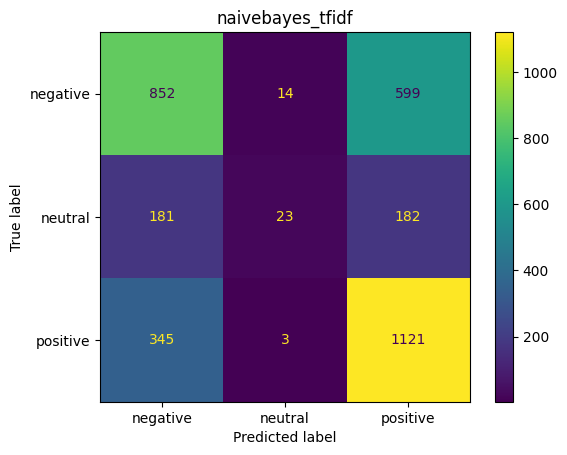

              precision    recall  f1-score   support

    negative       0.62      0.58      0.60      1465
     neutral       0.57      0.06      0.11       386
    positive       0.59      0.76      0.67      1469

    accuracy                           0.60      3320
   macro avg       0.59      0.47      0.46      3320
weighted avg       0.60      0.60      0.57      3320

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Model Building for Naive-Bayes using Word2Vec feature extraction
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ...........alpha=0.1, fit_prior=True;, score=nan total time=   0.0s
[CV 2/3] END ...........alpha=0.1, fit_prior=True;, score=nan total time=   0.0s
[CV 3/3] END ...........alpha=0.1, fit_prior=True;, score=nan total time=   0.0s
[CV 1/3] END ..........alpha=0.1, fit_prior=False;

<Figure size 640x480 with 0 Axes>

In [40]:
for model_name in ['Naive-Bayes']:
    for featuring_name, X_train_features, X_test_features in [
        ('TF-IDF', X_train_tfidf, X_test_tfidf),
        ('Word2Vec', X_train_word2vec, X_test_word2vec),
        ('BERT', X_train_bert, X_test_bert)
    ]:
        print(f'Model Building for {model_name} using {featuring_name} feature extraction')
        model_full_name = model_name + '_' + featuring_name
        model_full_name = model_full_name.replace('-', '').lower()

        try:
            model = build_model(X_train_features, y_train, model_name)
            
            with open(os.path.join(pickle_folder, f'{model_full_name}.pickle'), 'wb') as fo:
                pickle.dump(model, fo)
            
            y_pred = model.predict(X_test_features)
            show_metrics(y_test, y_pred, model_full_name)
            metrics.append({
                'Model': model_name,
                'Feature': featuring_name,
                'Accuracy': accuracy_score(y_test, y_pred),
                'F1_Score': f1_score(y_test, y_pred, average='weighted'),
                'Precision': precision_score(y_test, y_pred, average='weighted'),
                'Recall': recall_score(y_test, y_pred, average='weighted')
            })
        except Exception as e:
            print(f'Exception occured while building {model_full_name}\n{e}')
        print('-' * 200)
    print('=' * 200)

In [41]:
metrics

[{'Model': 'SVM',
  'Feature': 'TF-IDF',
  'Accuracy': 0.6759036144578313,
  'F1_Score': 0.6515372682154523,
  'Precision': 0.6742817458280368,
  'Recall': 0.6759036144578313},
 {'Model': 'SVM',
  'Feature': 'Word2Vec',
  'Accuracy': 0.5548192771084337,
  'F1_Score': 0.5314704822871515,
  'Precision': 0.5628532097096547,
  'Recall': 0.5548192771084337},
 {'Model': 'SVM',
  'Feature': 'BERT',
  'Accuracy': 0.6725903614457831,
  'F1_Score': 0.6600017429740271,
  'Precision': 0.6608318463258314,
  'Recall': 0.6725903614457831},
 {'Model': 'MLP',
  'Feature': 'TF-IDF',
  'Accuracy': 0.6078313253012049,
  'F1_Score': 0.6055576179255558,
  'Precision': 0.6071391892685131,
  'Recall': 0.6078313253012049},
 {'Model': 'MLP',
  'Feature': 'Word2Vec',
  'Accuracy': 0.5171686746987951,
  'F1_Score': 0.45333599161006777,
  'Precision': 0.5671899997651424,
  'Recall': 0.5171686746987951},
 {'Model': 'MLP',
  'Feature': 'BERT',
  'Accuracy': 0.6566265060240963,
  'F1_Score': 0.615960284849616,
  'Pre

In [42]:
df_metrics = pd.DataFrame(metrics)

In [43]:
df_metrics

,Model,Feature,Accuracy,F1_Score,Precision,Recall
0,SVM,TF-IDF,0.675904,0.651537,0.674282,0.675904
1,SVM,Word2Vec,0.554819,0.531470,0.562853,0.554819
2,SVM,BERT,0.672590,0.660002,0.660832,0.672590
3,MLP,TF-IDF,0.607831,0.605558,0.607139,0.607831
4,MLP,Word2Vec,0.517169,0.453336,0.567190,0.517169
5,MLP,BERT,0.656627,0.615960,0.580740,0.656627
6,Naive-Bayes,TF-IDF,0.601205,0.571314,0.600464,0.601205


## Model Deployment

In [44]:
final_model_name = 'svm_bert'
with open(os.path.join(pickle_folder, f'{final_model_name}.pickle'), 'rb') as fo:
    final_model = pickle.load(fo)

with open(os.path.join(pickle_folder, f'final_model.pickle'), 'wb') as fo:
    pickle.dump(final_model, fo)

In [ ]:
X_test_bert = get_bert_embeddings(X_test.to_list())

## Interface

In [49]:
import tkinter as tk
from tkinter import simpledialog

In [47]:
with open(os.path.join(pickle_folder, 'bert_tokenizer.pickle'), 'rb') as fo:
    tokenizer = pickle.load( fo)

with open(os.path.join(pickle_folder, 'bert_model.pickle'), 'rb') as fo:
    model = pickle.load(fo)

Testing the final model

In [48]:
user_input = "The gov funds billions in medicine research. How the gov don't have partial ownership on those patents blows my mind."
processed_input = preprocess_text(user_input)
X_test = get_bert_embeddings([processed_input])
sentiment = final_model.predict(X_test)
print(sentiment)

['neutral']


In [50]:
def submit_function():

    # Get user input from the Text widget
    # user_input = entry.get("1.0", tk.END).strip()
    #display_label.config('processing')
    # processed_input = preprocess_text(user_input)
    # display_label.config('vectorizing')
    # X_test = tfidf_vectorizer.transform(processed_input)
    # #X_test = get_word2vec_embeddings(processed_input)
    # display_label.config('predicting')
    # sentiment = final_model.predict(X_test)

    # # Display the prediction result in the label
    # result = f"Sentiment: {sentiment}"
    # display_label.config(text=result)

    user_input = entry.get("1.0", tk.END).strip()

    #prediction = 'Test'
    
    processed_input = preprocess_text(user_input)
    X_test = get_bert_embeddings([processed_input])
    sentiment = final_model.predict(X_test)
    
    result = f"Sentiment: {sentiment[0]}"
    display_label.config(text=result)

def clear_input():
    entry.delete("1.0", tk.END)
    display_label.config(text="")


# Creating the main window
root = tk.Tk()
root.title("Sentiment Analysis")

# Setting the size of the window (width x height)
root.geometry("500x300")

# Creating  multi-line user input box
entry = tk.Text(root, width=60, height=5)
entry.pack(pady=10)

# Creating the clear and submit buttons
submit_button = tk.Button(root, text="Submit", command=submit_function)
submit_button.pack(side=tk.RIGHT, padx=6, anchor=tk.N, pady=(5, 0))  # Adjusted padding

clear_button = tk.Button(root, text="Clear", command=clear_input)
clear_button.pack(side=tk.RIGHT, padx=6, anchor=tk.N, pady=(5, 0))  # Adjusted padding

display_label = tk.Label(root, text="")
display_label.pack(pady=70)

display_label.place(relx=1.0, x=-175, rely=0.5, anchor=tk.E)

# Running the Tkinter event loop
root.mainloop()